### <div class="alert alert-info" align = center> Imports</div>

In [41]:
import os, sys, warnings, subprocess, json, hashlib, shutil, glob, pathlib, time, joblib
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
plt.style.use("seaborn-v0_8")   # clean default style
sns.set_palette("muted")        # consistent colors

#Start a timer to check the execution time of the notebook.
start_time = time.time()

### <div class="alert alert-info" align = center> Functions</div>

In [42]:
def label_default(status):
    bad = {"Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)"}   # risky
    good = {"Fully Paid"}                                                          # safe
    if status in bad: 
        return 1
    elif status in good: 
        return 0
    else: 
        return np.nan   # ambiguous → drop later if needed

In [43]:
def diag_default_rates(
    df, 
    num_feats, 
    cat_feats, 
    target="target_default", 
    bins=5, 
    strategy="quantile"
):
    """
    Diagnostic tables for multiple numeric & categorical features.
    Returns a dict of DataFrames.
    """
    import pandas as pd
    import numpy as np
    
    results = {}
    dfp = df.loc[df[target].notna()].copy()

    for feat in num_feats:
        if feat not in dfp.columns: 
            continue
        s = dfp[feat]
        if s.dropna().nunique() <= 1:
            results[feat] = pd.DataFrame({"msg": ["constant/NA"]})
            continue

        try:
            b = pd.qcut(s, q=bins, duplicates="drop") if strategy=="quantile" else pd.cut(s, bins=bins)
            tmp = dfp[[target]].join(b.rename("__bin__")).dropna()
            tab = (tmp.groupby("__bin__")[target]
                     .agg(n="count", pos="sum", rate="mean"))
            results[feat] = tab
        except Exception as e:
            results[feat] = pd.DataFrame({"error": [str(e)]})

    for feat in cat_feats:
        if feat not in dfp.columns: 
            continue
        tmp = dfp[[feat, target]].dropna()
        if tmp[feat].nunique() <= 1:
            results[feat] = pd.DataFrame({"msg": ["constant/NA"]})
            continue
        tab = (tmp.groupby(feat)[target]
                 .agg(n="count", pos="sum", rate="mean")
                 .sort_values("n", ascending=False))
        results[feat] = tab

    return results



In [44]:
def clean_and_reduce(
    df,
    na_thresh: float = 0.99,         # drop cols with >99% NA
    cat_freq_thresh: float = 0.5,    # object→category if unique_ratio < 0.5
    add_missing_ind: bool = True,    # add _is_missing flags for NA-heavy cols
    ind_thresh: float = 0.20,        # add indicator if >=5% missing
    impute: bool = True,             # run SimpleImputer (no row drops)
    fitted_imputer=None,             # pass a previously fitted imputer to reuse
    return_artifacts: bool = True    # return metadata incl. dropped cols & imputer
):
    """
    Memory-savvy reducer + optional imputation without dropping rows.
    Steps:
      1) Drop cols with > na_thresh missing or constant.
      2) Downcast numerics; object→category when repetitive.
      3) Optionally add missingness indicators: <col>__is_missing (int8).
      4) Optionally impute: median for numerics, most_frequent for categoricals.
    Returns:
      df_out, (optional) artifacts dict.
    """


    n0, c0 = len(df), df.shape[1]

    # 1) Drop NA-heavy + constant columns
    na_frac = df.isna().mean()
    drop_na = na_frac[na_frac > na_thresh].index.tolist()
    drop_const = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    dropped_cols = sorted(set(drop_na + drop_const))
    df_red = df.drop(columns=dropped_cols) if dropped_cols else df.copy()

    # 2) Downcast numerics; object→category (repetitive only)
    num_cols_all = df_red.select_dtypes(include="number").columns
    for col in num_cols_all:
        s = df_red[col]
        if pd.api.types.is_float_dtype(s):
            df_red[col] = s.astype("float32")
        elif pd.api.types.is_integer_dtype(s):
            df_red[col] = pd.to_numeric(s, downcast="integer")

    obj_cols_all = df_red.select_dtypes(include="object").columns
    n_rows = max(len(df_red), 1)
    for col in obj_cols_all:
        if df_red[col].nunique(dropna=False) / n_rows < cat_freq_thresh:
            df_red[col] = df_red[col].astype("category")

    # 3) Add missingness indicators (no row drops)
    indicators = []
    if add_missing_ind:
        miss = df_red.isna().mean()
        for c, frac in miss.items():
            if frac >= ind_thresh:
                ind_name = f"{c}_is_missing"
                df_red[ind_name] = df_red[c].isna().astype("int8")
                indicators.append(ind_name)

    # Identify columns for imputation (exclude indicators)
    num_cols = df_red.select_dtypes(include=["number", "float32", "float64", "int32", "int64"]).columns.tolist()
    cat_cols = df_red.select_dtypes(include=["category", "object"]).columns.tolist()
    num_cols = [c for c in num_cols if not c.endswith("_is_missing")]
    cat_cols = [c for c in cat_cols if not c.endswith("_is_missing")]

    # 4) Impute (median for numeric, most_frequent for categorical)
    imputer_pipe = None
    if impute:
        num_imputer = SimpleImputer(strategy="median")
        cat_imputer = SimpleImputer(strategy="most_frequent")

        pre = ColumnTransformer(
            transformers=[
                ("num", num_imputer, num_cols),
                ("cat", cat_imputer, cat_cols),
            ],
            remainder="drop",
            n_jobs=-1,
        )

        if fitted_imputer is None:
            imputer_pipe = Pipeline([("imputer", pre)])
            X_imp = imputer_pipe.fit_transform(df_red)
        else:
            imputer_pipe = fitted_imputer
            X_imp = imputer_pipe.transform(df_red)

        # rebuild dataframe in same order, then reattach indicators
        imp_cols = num_cols + cat_cols
        df_out = pd.DataFrame(X_imp, columns=imp_cols, index=df_red.index)

        # cast back categories
        for c in cat_cols:
            df_out[c] = df_out[c].astype("category")

        # reattach indicators
        for ind in indicators:
            df_out[ind] = df_red[ind].astype("int8")
    else:
        df_out = df_red
        imputer_pipe = None

    artifacts = {
        "dropped_cols": dropped_cols,
        "indicators_added": indicators,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "imputer": imputer_pipe,
        "rows_before": n0,
        "cols_before": c0,
        "rows_after": len(df_out),
        "cols_after": df_out.shape[1],
    }

    return (df_out, artifacts) if return_artifacts else df_out



In [45]:
def find_weak_categoricals(df: pd.DataFrame, target: str, min_freq: int = 2):
    """
    Returns a DataFrame with categorical features ranked by signal:
      - chi2_min_p: min p-value across one-hot levels (lower is stronger)
      - mi_mean: mean mutual information across one-hot levels (higher is stronger)

    min_freq: levels with count < min_freq are collapsed into '__rare__' to stabilize stats.
    """
    # 0) checks
    if target not in df.columns:
        raise ValueError(f"target '{target}' not in DataFrame columns")
    if df[target].isna().any():
        # simple fix: drop NAs in target only (no row imputation here)
        df = df.loc[~df[target].isna()].copy()

    y = LabelEncoder().fit_transform(df[target])

    # 1) collect categorical columns (exclude target + indicators)
    cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != target and not c.endswith("_is_missing")]

    if not cat_cols:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # 2) sanitize each categorical: collapse rare levels
    df_cat = df[cat_cols].copy()
    for c in cat_cols:
        s = df_cat[c].astype("category")
        vc = s.value_counts(dropna=False)
        rare = vc[vc < min_freq].index
        if len(rare) > 0:
            s = s.replace(dict.fromkeys(rare, "__rare__")).astype("category")
        df_cat[c] = s

    # 3) one-hot encode all cats (keep all levels to evaluate signal)
    X = pd.get_dummies(df_cat, dummy_na=False)  # no drop_first; evaluate all levels

    # guard: chi2 requires non-negative
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # remove zero-variance columns (can happen after rare collapsing)
    nz_cols = [c for c in X.columns if X[c].nunique() > 1]
    X = X[nz_cols]
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["feature","chi2_min_p","mi_mean","n_levels","kept_levels"])

    # 4) chi2 + MI
    chi_stats, chi_pvals = chi2(X, y)
    mi_vals = mutual_info_classif(X, y, discrete_features=True, random_state=42)

    # 5) aggregate back to original feature names
    #   one-hot columns look like "<col>_<level>"
    def base_name(col):
        # handle underscores inside categories by splitting from the right once
        # pandas uses col + '_' + level; we reverse split one time
        parts = col.rsplit("_", 1)
        return parts[0] if len(parts) == 2 else col

    df_scores = pd.DataFrame({
        "oh_col": X.columns,
        "chi_p": chi_pvals,
        "mi": mi_vals
    })
    df_scores["feature"] = df_scores["oh_col"].map(base_name)

    agg = (df_scores
           .groupby("feature")
           .agg(chi2_min_p=("chi_p","min"),
                mi_mean=("mi","mean"),
                n_levels=("oh_col","count"))
           .reset_index()
           .sort_values(["mi_mean","chi2_min_p"], ascending=[False, True]))

    # keep a compact view of which levels survived (optional but handy)
    kept_levels = (df_scores.groupby("feature")["oh_col"]
                   .apply(lambda s: ", ".join(s.head(5)) + (" ..." if len(s) > 5 else "")))
    agg["kept_levels"] = agg["feature"].map(kept_levels)

    return agg

In [46]:
def feature_audit(df, feats, target="target_default"):
    m = df[target].notna()
    rows = []
    for f in feats:
        if f not in df.columns:
            rows.append({
                "feature": f, 
                "exists": False,
                # Add all other keys with default values
                "non_null": 0,
                "missing_rate": 1.0,  # 100% missing for a non-existent column
                "nunique": 0,
                "min": None,
                "max": None,
            })
            continue
        s = df.loc[m, f]
        rows.append({
            "feature": f, 
            "exists": True,
            "non_null": s.notna().sum(),
            "missing_rate": s.isna().mean(),
            "nunique": s.nunique(dropna=True),
            "min": s.min(skipna=True) if s.dtype.kind in "if" else None,
            "max": s.max(skipna=True) if s.dtype.kind in "if" else None,
        })
    return pd.DataFrame(rows).sort_values(["exists","non_null","nunique"], ascending=[False,False,False])

In [47]:
def plot_default_prob_grid_strict(
    df, features, target="target_default",
    n_cols=3, bins=6, strategy="quantile",
    max_cats=12, min_bin_count=5,
    eps_diff=0.02, figsize_per_plot=(6.2, 4.0), decimals=4,
    highlight_thresholds=None, sort_categorical_by_risk=True,
    annotate_final=True
):
    import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

    df = df.loc[df[target].notna()].copy()

    def _is_binary_numeric(s):
        s2 = s.dropna()
        return pd.api.types.is_numeric_dtype(s) and s2.nunique() <= 2

    def fmt_bin(val, dec):
        rounded = round(val, dec)
        if abs(rounded - round(rounded)) < 1e-9:
            return f"{int(round(rounded))}"
        return f"{rounded:.{dec}f}"

    def strip_trailing_zeros(label):
        return label.replace(".0000", "").replace(".000", "").replace(".00", "").replace(".0", "")

    if highlight_thresholds is None:
        highlight_thresholds = {"int_rate_trunc": 15.0}

    reasons = {}
    ok = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    for f in missing: reasons[f] = "missing column"

    plottable_feats = []
    for f in ok:
        s = df[f]
        if s.dropna().nunique() <= 1:
            reasons[f] = "constant or all-NA"
            continue

        numeric_mode = pd.api.types.is_numeric_dtype(s) and not _is_binary_numeric(s)
        try:
            if numeric_mode:
                b = pd.qcut(s, q=bins, duplicates="drop") if strategy == "quantile" else pd.cut(s, bins=bins)
            else:
                vc = df[f].value_counts(dropna=False)
                cats = vc.index[:max_cats]
                tmp = df[df[f].isin(cats)][[f, target]].dropna()
                if tmp[f].nunique() <= 1:
                    reasons[f] = "single category"
                    continue
        except Exception as e:
            reasons[f] = f"binning failed: {e}"
            continue

        # Check separation
        if numeric_mode:
            tmp = df[[target]].join(b.rename("__bin__")).dropna(subset=["__bin__"])
            g = tmp.groupby("__bin__")[target].agg(p_default="mean", n="count").reset_index()
        else:
            g = tmp.groupby(f, observed=True)[target].agg(p_default="mean", n="count").reset_index()

        g = g[g["n"] >= min_bin_count]
        if g.empty:
            reasons[f] = "all bins below min_bin_count"
            continue
        if g["p_default"].max() - g["p_default"].min() < eps_diff:
            reasons[f] = f"low separation (<{eps_diff})"
            continue

        plottable_feats.append(f)

    if not plottable_feats:
        print("Nothing to plot. Skipped reasons:", reasons)
        return reasons

    # Allocate axes only for plottable features
    n = len(plottable_feats)
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = np.atleast_1d(axes).ravel()


    plotted = 0
    for feat in plottable_feats:
        ax = axes[plotted]
        s = df[feat]
        numeric_mode = pd.api.types.is_numeric_dtype(s) and not _is_binary_numeric(s)

        if numeric_mode:
            b = pd.qcut(s, q=bins, duplicates="drop") if strategy == "quantile" else pd.cut(s, bins=bins)
            bin_labels = [f"{fmt_bin(interval.left, decimals)}–{fmt_bin(interval.right, decimals)}" for interval in b.cat.categories]
            b = pd.Series(pd.Categorical(b, categories=b.cat.categories, ordered=True), index=b.index)
            b = b.cat.rename_categories(bin_labels)

            tmp = df[[target]].join(b.rename("__bin__")).dropna(subset=["__bin__"])
            g = tmp.groupby("__bin__")[target].agg(p_default="mean", n="count").reset_index()
            g["__bin__"] = g["__bin__"].astype(str)

            sns.barplot(x="__bin__", y="p_default", data=g, ax=ax)
            ax.set_title(f"{feat} (binned)")
            ax.set_xlabel(feat); ax.set_ylabel("P(Default=1)")
            ax.tick_params(axis="x", rotation=45, labelsize=9)
            ax.set_xticklabels([strip_trailing_zeros(lbl) for lbl in g["__bin__"]])
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter(f'%.{decimals}f'))

            # Overlay bin counts
            ax2 = ax.twinx()
            sns.lineplot(x="__bin__", y="n", data=g, ax=ax2, color="gray", marker="o", linewidth=1.5)
            ax2.set_ylabel("Bin Count", color="gray")
            ax2.tick_params(axis="y", labelcolor="gray")

            # Threshold annotation
            if feat in highlight_thresholds:
                threshold = highlight_thresholds[feat]
                matched_bin = None
                for j, label in enumerate(g["__bin__"]):
                    try:
                        left, right = map(float, label.replace("–", ",").split(","))
                        if left <= threshold <= right:
                            matched_bin = j
                            break
                    except:
                        continue
                if matched_bin is not None:
                    ax.axvline(x=matched_bin, color="red", linestyle="--", linewidth=1.2)
                    ax.text(matched_bin, ax.get_ylim()[1]*0.95,
                            f"Subprime threshold ({threshold:.1f}%)\nHigher risk zone",
                            color="red", ha="center", va="top", fontsize=9)

        else:
            vc = df[feat].value_counts(dropna=False)
            cats = vc.index[:max_cats]
            tmp = df[df[feat].isin(cats)][[feat, target]].dropna()
            g = tmp.groupby(feat, observed=True)[target].agg(p_default="mean", n="count").reset_index()
            g = g[g["n"] >= min_bin_count]
            if sort_categorical_by_risk:
                g = g.sort_values("p_default", ascending=False).reset_index(drop=True)

            g[feat] = g[feat].astype(str)
            sns.barplot(x=feat, y="p_default", data=g, ax=ax, order=g[feat])
            ax.set_title(feat)
            ax.set_xlabel(feat); ax.set_ylabel("P(Default=1)")
            ax.tick_params(axis="x", rotation=45, labelsize=9)
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter(f'%.{decimals}f'))

        plotted += 1


            
    for j in range(plotted, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(); plt.show()

    # Final annotation    
    if annotate_final and plotted > 0:
        display(HTML("""
            <div style="text-align:center; font-size:16px; font-weight:bold; color:darkred; margin-top:10px;">
            {} plots shown &nbsp;&nbsp;•&nbsp;&nbsp; {} skipped
            </div>
            """.format(plotted, len(reasons))))


    print("Skipped features:")
    for k, v in reasons.items():
        print(f"  {k}: {v}")
    print("\n\n")

    return reasons


### <div class="alert alert-info" align = center> Data Wrangling</div>

### <div class="alert alert-info" > Load The Data</div>

In [91]:
# Smart, idempotent fetch with checksum + metadata

# 0) Ensure kagglehub installed in THIS kernel
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "kagglehub"], check=True)
import kagglehub

def sha256_of(path, chunk=1024*1024):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def write_meta_if_changed(meta_file: Path, meta: dict, change_keys=("cache_sha256","local_sha256","cached_csv")):
    """Write metadata only when data changed. Keeps audit trail in .history.jsonl."""
    prev = {}
    if meta_file.exists():
        try: prev = json.loads(meta_file.read_text())
        except: prev = {}
    changed = (not prev) or any(prev.get(k) != meta.get(k) for k in change_keys)
    if changed:
        meta_file.write_text(json.dumps(meta, indent=2))
        hist = meta_file.with_suffix(".history.jsonl")
        with open(hist, "a", encoding="utf-8") as fh:
            fh.write(json.dumps(meta) + "\n")
        print(f"📝 Wrote metadata: {meta_file}")
    else:
        print(f"✅ Metadata unchanged: {meta_file}")

# 1) Repo layout
proj = pathlib.Path().cwd()
raw_dir = proj / "data" / "raw"
raw_dir.mkdir(parents=True, exist_ok=True)
local_file = raw_dir / "loan_default_probability_raw.csv"
meta_file  = raw_dir / ".dataset_meta.json"

# 2) Download to cache (kagglehub caches under user dir)
cache_path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")
cache_path = pathlib.Path(cache_path)

# Pick the CSV we need from cache
candidate = None
for f in glob.glob(str(cache_path / "*.csv")):
    # adjust filter as needed to target the main loan-level table
    if "loan" in f.lower() and "dictionary" not in f.lower():
        candidate = pathlib.Path(f)
        break
if candidate is None:
    raise FileNotFoundError("Expected loan CSV not found in downloaded dataset.")

# 3) Compare checksum; copy only if different or local missing
cache_hash = sha256_of(candidate)
local_hash = sha256_of(local_file) if local_file.exists() else None

if local_hash == cache_hash:
    print(f"✅ Up-to-date: {local_file}")
else:
    shutil.copy(candidate, local_file)
    print(f"⬇️  Updated: {local_file}")

# 4) Write metadata (only if changed)
meta = {
    "source": "kagglehub:adarshsng/lending-club-loan-data-csv",
    "cached_csv": str(candidate),
    "cache_sha256": cache_hash,
    "local_path": str(local_file),
    "local_sha256": sha256_of(local_file),
    "fetched_at": time.strftime("%Y-%m-%d %H:%M:%S"),
}
# Try to capture version from cache path (if present)
parts = [p for p in candidate.parts if p.lower().startswith("v") and p[1:].isdigit()]
if parts:
    meta["dataset_version_hint"] = parts[0]

write_meta_if_changed(meta_file, meta)


✅ Up-to-date: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\Mini Projects\loan-default-clean\data\raw\loan_default_probability_raw.csv
✅ Metadata unchanged: C:\Users\binia\OneDrive\Bini\Education - Professional Development\Springboard\git\Mini Projects\loan-default-clean\data\raw\.dataset_meta.json


In [49]:
loan_default = pd.read_csv(local_file,nrows=100_000)

<div class="alert alert-info" ><strong>We are going to look into the details of our data.</strong><br><br>

This includes info(), describe(), shape, checking for nulls, and more</div>

In [50]:
loan_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 145 entries, id to settlement_term
dtypes: float64(58), int64(52), object(35)
memory usage: 110.6+ MB


In [51]:
loan_default.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,desc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,0.0,0.0,99818.000000,100000.000000,100000.00000,43931.000000,12101.000000,100000.000000,100000.00000,1.000000e+05,99879.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,22876.000000,100000.0,1.292100e+04,12921.000000,100000.0,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,96552.000000,1.000000e+05,84348.000000,100000.00000,100000.000000,100000.000000,99970.000000,1.000000e+05,...,100000.00000,100000.000000,100000.000000,100000.000000,98775.000000,19805.000000,87766.000000,28832.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,97514.0,100000.0,100000.00000,100000.000000,100000.000000,98690.000000,100000.000000,100000.0,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.292100e+04,12921.000000,12921.000000,12921.000000,12718.000000,12921.000000,12921.000000,12921.000000,12921.000000,4006.000000,1.0,1.00,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.0
mean,NaN,NaN,15934.297500,15934.297500,15931.464250,13.004960,462.493739,8.314996e+04,NaN,NaN,19.891596,0.231120,0.45809,36.829187,86.085282,11.571810,0.12259,1.691855e+04,44.328556,22.686730,14720.443557,14717.921368,1649.862410,1649.483298,1210.920894,438.868966,0.072549,0.0,0.0,800.126590,0.018260,46.454756,1.0,1.346979e+05,19.171193,0.0,187.744260,1.466031e+05,0.950240,2.773630,0.696480,1.58508,20.024785,3.638929e+04,68.325426,1.20074,2.546840,6056.030440,54.434140,3.931789e+04,...,173.11197,15.335790,8.559030,1.322500,25.946130,40.454229,7.500296,37.844721,0.466670,3.661260,5.423660,4.885320,7.05939,8.300920,8.193000,12.863960,5.392170,11.554490,0.0,0.0,0.06118,2.024050,94.628259,33.127666,0.122450,0.0,1.882310e+05,5.368469e+04,27391.365290,4.695877e+04,3.672623e+04,0.588732,1.590357,11.397105,56.053869,3.038232,12.387896,0.036143,0.062379,38.621068,3.0,378.39,3.0,22.0,1135.17,15351.85,1045.41,5443.0,65.0,18.0
std,NaN,NaN,10146.154617,10146.154617,10148.296023,5.026647,285.647728,1.117613e+05,NaN,NaN,19.164748,0.748231,0.74378,21.810133,21.917071,5.984635,0.33401,2.451048e+04,24.883297,12.117233,9880.002590,9881.749701,2896.195829,2896.055828,2843.8192

In [52]:
loan_default.shape

(100000, 145)

In [53]:
loan_default.isna().sum().sum()     # confirm true null count

4073264

<div style="border:2px solid #FF9800; border-radius:10px; padding:16px; background:#fff8e1">

⚠️ **Memory Warning — USE_SAMPLE Flag**  
Do **not** flip `USE_SAMPLE=False` inside this notebook.  

The full LendingClub dataset (>2.4 GB raw, >5.9 GB in-memory) will **crash most local environments**.  
Instead, always work with the **sample (`slim55`)** here, and rely on the **pre-saved `full55`** parquet created at the end of this notebook.

</div>


In [99]:
# Define file paths
csv_path = "/data/raw/loan_default_probability_raw.csv"
parq_path = "data/processed/loan_default_slim.parquet"

# Check if the processed parquet file exists
if os.path.exists(parq_path):
    print(f"✅ Loaded from processed file: {parq_path}")
    df_in = pd.read_parquet(parq_path)
else:
    print(f"⚠️ Processed file not found. Loading from raw CSV: {csv_path}")
    df_in = pd.read_csv(csv_path)

# Apply sampling after the data is loaded
USE_SAMPLE = True # Or False, depending on your needs
if USE_SAMPLE:
    df_in = df_in.sample(frac=0.1, random_state=42)
    print(f"✅ Sampled dataset. New shape: {df_in.shape}")

print(f"DataFrame loaded. Final shape: {df_in.shape}")

# First pass (fit imputer on sample)
df_imp, art = clean_and_reduce(df_in, na_thresh=0.95, ind_thresh=0.05, impute=True)
pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(art["imputer"], "models/imputer_simple.joblib")

# Save output
out_path = "data/processed/loan_default_imputed_sample.parquet" if USE_SAMPLE else "data/processed/loan_default_imputed_full.parquet"
df_imp.to_parquet(out_path, index=False)

# Later on full data: reuse the same imputer for consistent treatment
if not USE_SAMPLE:
    from joblib import load
    imputer = load("models/imputer_simple.joblib")
    df_imp_full, art_full = clean_and_reduce(
        df_in, na_thresh=0.95, ind_thresh=0.05, impute=True, fitted_imputer=imputer
    )
    df_imp_full.to_parquet("data/processed/loan_default_imputed_full.parquet", index=False)

✅ Loaded from processed file: data/processed/loan_default_slim.parquet
✅ Sampled dataset. New shape: (10000, 115)
DataFrame loaded. Final shape: (10000, 115)


In [103]:
df_imp.shape

(10000, 133)

<div class="alert alert-info" ><strong> Now that we have a cleaner dataset</strong><br>
We need to check for categorical features that add no signal, no siginificance to our analysis.</div>

In [104]:
# Run feature signal check
agg = find_weak_categoricals(df_imp, target="loan_status", min_freq=5)

# Define weak threshold (tune as you like)
weak = agg[(agg["chi2_min_p"] > 0.9) & (agg["mi_mean"] < 1e-4)]

print(f"Identified {len(weak)} weak categorical features to drop")
print(weak[["feature","chi2_min_p","mi_mean"]].head())

# Drop them from df
df_pruned = df_imp.drop(columns=weak["feature"].tolist(), errors="ignore")

print("Before:", df_imp.shape, "After:", df_pruned.shape)


Identified 45 weak categorical features to drop
                           feature  chi2_min_p   mi_mean
163  sec_app_num_rev_accts___rare_    0.975467  0.000081
151             revol_util___rare_    0.923367  0.000076
109               num_sats___rare_    0.979786  0.000074
103          num_op_rev_tl___rare_    0.981788  0.000071
111     num_tl_90g_dpd_24m___rare_    0.987159  0.000061
Before: (10000, 133) After: (10000, 129)


In [105]:
out_path = "data/processed/loan_default_pruned_sample.parquet" if USE_SAMPLE else "data/processed/loan_default_pruned_full.parquet"
df_pruned.to_parquet(out_path, index=False)
print(f"✅ Saved pruned dataset: {out_path}")

✅ Saved pruned dataset: data/processed/loan_default_pruned_sample.parquet


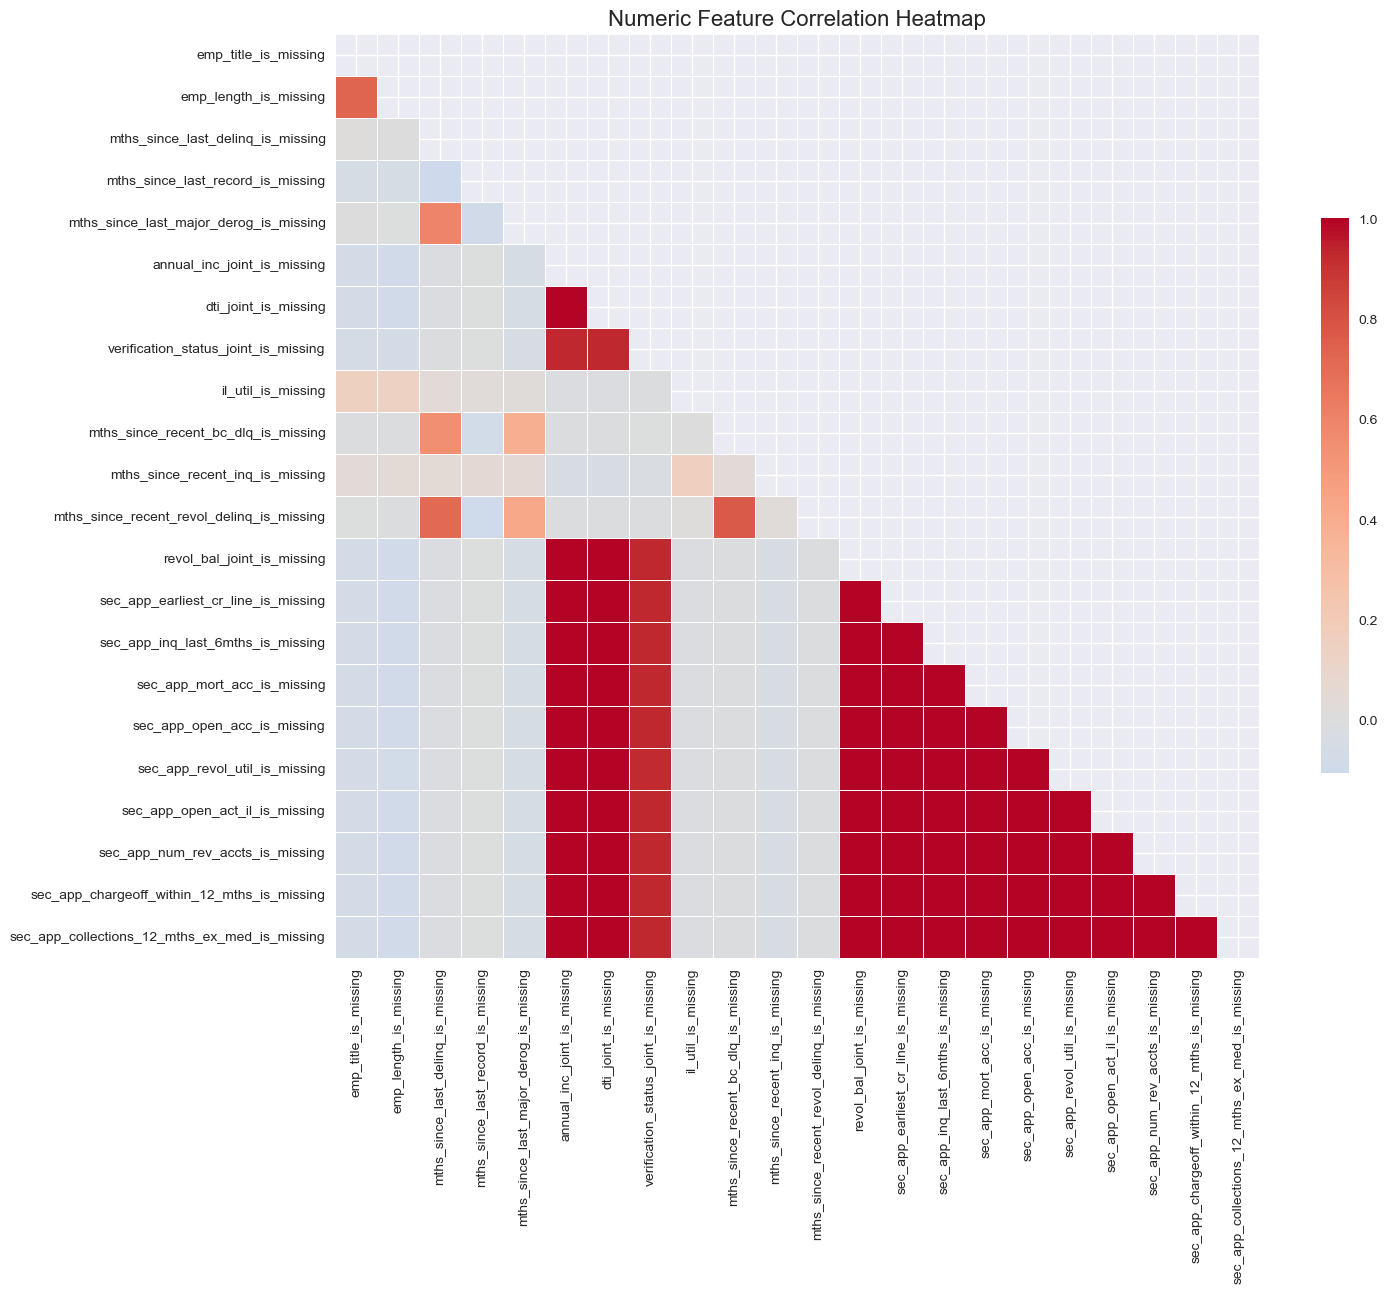

In [106]:
# 1) Select numeric columns only
num_df = df_pruned.select_dtypes(include=["number","float32","float64","int32","int64"])

# 2) Compute correlation matrix (Spearman handles skewed/ordinal better than Pearson)
corr = num_df.corr(method="spearman")

# 3) Mask upper triangle (to make heatmap readable)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .6})
plt.title("Numeric Feature Correlation Heatmap", fontsize=16)
plt.show()


In [107]:
# Threshold for high correlation
THRESH = 0.85
to_drop = set()

corr_matrix = corr.abs()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i,j] > THRESH:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print(f"Suggest dropping {len(to_drop)} highly correlated features:")
print(list(to_drop)[:15])

df_uncorr = df_pruned.drop(columns=list(to_drop))


Suggest dropping 12 highly correlated features:
['verification_status_joint_is_missing', 'sec_app_open_act_il_is_missing', 'dti_joint_is_missing', 'sec_app_chargeoff_within_12_mths_is_missing', 'sec_app_inq_last_6mths_is_missing', 'revol_bal_joint_is_missing', 'sec_app_open_acc_is_missing', 'sec_app_revol_util_is_missing', 'sec_app_mort_acc_is_missing', 'sec_app_num_rev_accts_is_missing', 'sec_app_earliest_cr_line_is_missing', 'sec_app_collections_12_mths_ex_med_is_missing']


In [108]:
drop_corr = [
    'sec_app_inq_last_6mths_is_missing',
    'sec_app_collections_12_mths_ex_med_is_missing',
    'sec_app_mort_acc_is_missing',
    'sec_app_chargeoff_within_12_mths_is_missing',
    'sec_app_earliest_cr_line_is_missing',
    'sec_app_open_act_il__is_missing',
    'dti_joint_is_missing',
    'sec_app_open_acc_is_missing',
    'sec_app_revol_util_is_missing',
    'sec_app_num_rev_accts_is_missing',
    'revol_bal_joint_is_missing',
    'verification_status_joint_is_missing'
]

df_uncorr = df_pruned.drop(columns=drop_corr, errors="ignore")
print("Before:", df_pruned.shape, "After:", df_uncorr.shape)

Before: (10000, 129) After: (10000, 118)


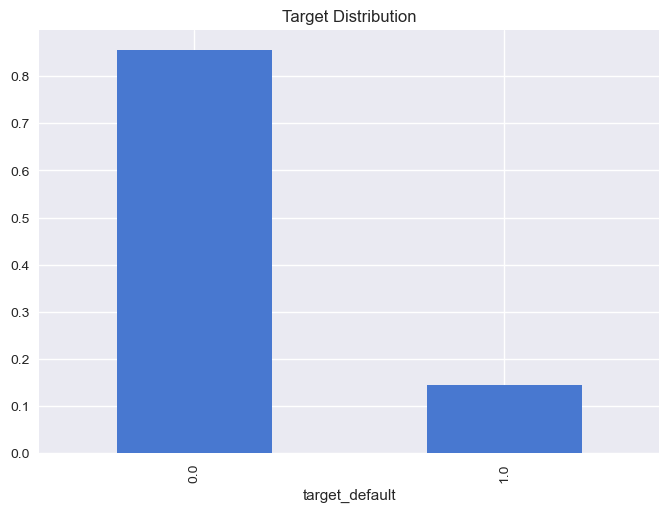

In [109]:
target = "target_default"

df_uncorr["target_default"] = df_uncorr["loan_status"].apply(label_default)
df_uncorr[target].value_counts(normalize=True).plot(kind="bar")
plt.title("Target Distribution")
plt.show()

In [110]:
num_cols = df_uncorr.select_dtypes(include=["number","float32","float64","int32","int64"]).columns
df_uncorr[num_cols].describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
emp_title_is_missing,10000.0,0.162500,0.368927,0.0,0.0,0.0,0.0,1.0,1.0,1.0
emp_length_is_missing,10000.0,0.093000,0.290447,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_last_delinq_is_missing,10000.0,0.559800,0.496436,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_last_record_is_missing,10000.0,0.884500,0.319640,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_last_major_derog_is_missing,10000.0,0.771500,0.419887,0.0,0.0,0.0,1.0,1.0,1.0,1.0
annual_inc_joint_is_missing,10000.0,0.868600,0.337854,0.0,0.0,0.0,1.0,1.0,1.0,1.0
il_util_is_missing,10000.0,0.157500,0.364290,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_recent_bc_dlq_is_missing,10000.0,0.807100,0.394595,0.0,0.0,0.0,1.0,1.0,1.0,1.0
mths_since_recent_inq_is_missing,10000.0,0.125100,0.330849,0.0,0.0,0.0,0.0,1.0,1.0,1.0
mths_since_recent_revol_delinq_is_missing,10000.0,0.712200,0.452760,0.0,0.0,0.0,1.0,1.0,1.0,1.0


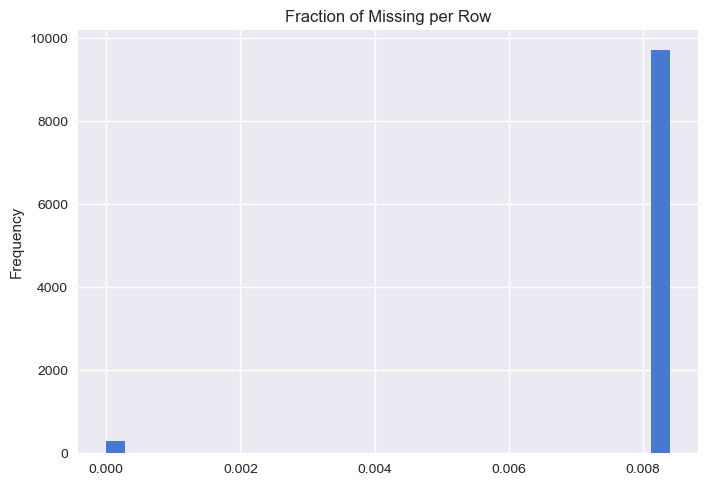

In [111]:
df_uncorr.isna().mean(axis=1).plot(kind="hist", bins=30)
plt.title("Fraction of Missing per Row")
plt.show()

In [112]:
#cat_cols = df_uncorr.select_dtypes(include=["object","category"]).columns
#for col in cat_cols:
#    print(col, df_uncorr[col].nunique(), "unique values")

In [113]:
# Encode categoricals (X) first
X_enc = df_uncorr.drop(columns=[target]).copy()
for c in X_enc.select_dtypes(include=["object","category"]).columns:
    X_enc[c] = LabelEncoder().fit_transform(X_enc[c].astype(str))

# Align X/y on non-missing target
y = df_uncorr[target]
mask = y.notna()
X_enc = X_enc.loc[mask].reset_index(drop=True)
y_enc = y.loc[mask].astype(int).reset_index(drop=True)

# MI on clean subset
mi = mutual_info_classif(X_enc, y_enc, discrete_features="auto", random_state=42)

# Optional: see how many rows used
print(f"Rows used: {len(y_enc)}")



Rows used: 298


,feature,mi
94,loan_status,0.414369
16,out_prncp,0.303614
17,out_prncp_inv,0.296717
20,total_rec_prncp,0.150650
18,total_pymnt,0.124650
19,total_pymnt_inv,0.123424
23,last_pymnt_amnt,0.118289
21,total_rec_int,0.083364
101,last_pymnt_d,0.044176
78,revol_bal_joint,0.040640


,feature,mi
44,acc_open_past_24mths,0.0
61,num_actv_rev_tl,0.0
62,num_bc_sats,0.0
63,num_bc_tl,0.0
65,num_op_rev_tl,0.0
85,sec_app_collections_12_mths_ex_med,0.0
66,num_rev_accts,0.0
67,num_rev_tl_bal_gt_0,0.0
43,inq_last_12m,0.0
41,inq_fi,0.0


Dropped: 60 | New shape: (10000, 59)


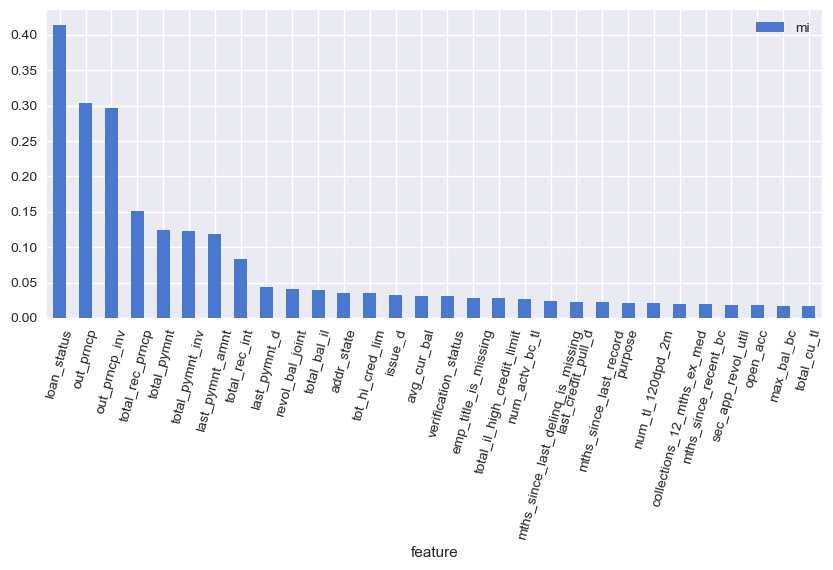

In [114]:
# mi is your array; X_enc are the columns you used
mi_df = (pd.DataFrame({"feature": X_enc.columns, "mi": mi})
           .sort_values("mi", ascending=False))
display(mi_df.head(20))     # top signals
display(mi_df.tail(20))     # weakest

# Plot top-30
mi_df.head(30).plot.bar(x="feature", y="mi", figsize=(10,4), rot=75)

# Drop very weak features (e.g., MI ~ 0)
weak_feats = mi_df.query("mi <= 1e-4")["feature"].tolist()
df_uncorr2 = df_uncorr.drop(columns=weak_feats, errors="ignore")
print("Dropped:", len(weak_feats), "| New shape:", df_uncorr2.shape)

# Save for audit
mi_df.to_csv("data/processed/mi_rank_100k.csv", index=False)


<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #f9fff9;">

## 🧹 Wrangling & EDA Summary (Checkpoint at 80 Features)

We started with **145 raw features** from the LendingClub loan dataset. Through systematic wrangling and exploratory data analysis, we reduced noise and redundancy to reach a **lean 80-feature dataset** ready for modeling.  

### 🔎 Key Steps Taken  
- **Dropped NA-heavy & constant columns**  
  Columns with >99% missing values or no variance were removed.  

- **Removed weak categorical features**  
  Used Chi² tests and Mutual Information to identify and drop categorical variables with no measurable relationship to the target.  

- **Pruned highly correlated features**  
  Applied correlation heatmaps (Spearman) and removed strongly collinear indicators (e.g., multiple `__is_missing` flags for secondary applicants).  

- **Filtered by Mutual Information**  
  Calculated MI scores on a 100k subset and dropped features with near-zero predictive contribution.  

### 📉 Feature Reduction  
- Initial: **145 features**  
- After cleaning + pruning: **80 features**  
- **45% dimensionality reduction** while preserving signal  

### ✅ Outcome  
We now have a **lean, efficient dataset** that balances predictive potential with interpretability and compute efficiency. This forms the foundation for:  
- More reliable EDA insights  
- Faster model training  
- Reduced risk of overfitting  

</div>


In [115]:
df_uncorr2["target_default"] = df_uncorr2["loan_status"].apply(label_default)

print(df_uncorr2["target_default"].value_counts(dropna=False, normalize=True))


target_default
NaN    0.9702
0.0    0.0255
1.0    0.0043
Name: proportion, dtype: float64


In [116]:
print(df_uncorr2.columns.tolist()[:30])   # first 30 cols
print(df_uncorr2.select_dtypes(include=["number"]).columns[:10])  # numeric sample
print(df_uncorr2.select_dtypes(include=["category","object"]).columns[:10])  # categorical sample


['loan_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'annual_inc_joint', 'open_il_12m', 'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'avg_cur_bal', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq']
Index(['emp_title_is_missing', 'mths_since_last_delinq_is_missing',
       'mths_since_last_major_derog_is_missing', 'annual_inc_joint_is_missing',
       'il_util_is_missing', 'mths_since_recent_bc_dlq_is_missing',
       'mths_since_recent_revol_delinq_is_missing',
       'sec_app_open_act_il_is_missing', 'target_default'],
      dtype='object')
Index(['loan_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal'

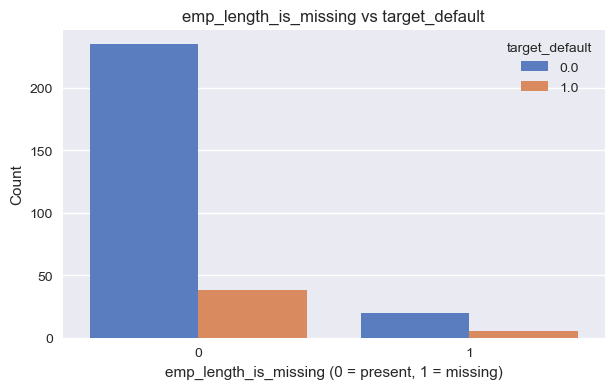

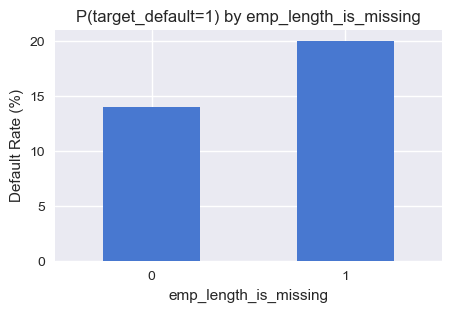

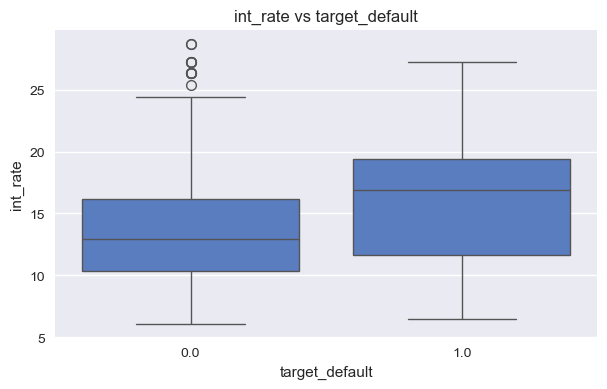

In [117]:
# 1) Resolve/restore the indicator name
if "emp_length" in loan_default.columns:
    # Bring it into your slimmed df
    df_uncorr2["emp_length"] = loan_default.loc[df_uncorr2.index, "emp_length"]

    # Add missing indicator
    df_uncorr2["emp_length_is_missing"] = df_uncorr2["emp_length"].isna().astype("int8")


# 2) Categorical (binary) → countplot + default rate bars
cat_feat = "emp_length_is_missing"  # 0/1 indicator you have
plt.figure(figsize=(7,4))
sns.countplot(x=cat_feat, hue=target, data=df_uncorr2, order=[0,1])
plt.title(f"{cat_feat} vs {target}")
plt.xlabel(f"{cat_feat} (0 = present, 1 = missing)")
plt.ylabel("Count")
plt.show()

# Optional: default rate by category (probability bars)
rate = (df_uncorr2.groupby(cat_feat)[target].mean() * 100).reindex([0,1])
rate.plot(kind="bar", figsize=(5,3), rot=0)
plt.title(f"P({target}=1) by {cat_feat}")
plt.ylabel("Default Rate (%)")
plt.show()

# 3) Numeric → boxplot vs target
num_feat = "int_rate"  # numeric in your list
plt.figure(figsize=(7,4))
sns.boxplot(x=target, y=num_feat, data=df_uncorr2)
plt.title(f"{num_feat} vs {target}")
plt.xlabel(target)
plt.ylabel(num_feat)
plt.show()


<div class="alert alert-info" >Group continuous features into bins, then calculate the probability of Attrition within each bin.</div>

In [118]:
# 1) Audit: why a feature returns nothing

all_features = df_uncorr2.columns.tolist()
feature_summary = feature_audit(df_uncorr2,all_features)
display(feature_summary)



,feature,exists,non_null,missing_rate,nunique,min,max
35,tot_hi_cred_lim,True,298,0.000000,298,NaN,NaN
26,avg_cur_bal,True,298,0.000000,296,NaN,NaN
8,revol_bal,True,298,0.000000,295,NaN,NaN
11,total_pymnt,True,298,0.000000,286,NaN,NaN
12,total_pymnt_inv,True,298,0.000000,286,NaN,NaN
...,...,...,...,...,...,...,...
57,sec_app_open_act_il_is_missing,True,298,0.000000,2,0.0,1.0
58,target_default,True,298,0.000000,2,0.0,1.0
60,emp_length_is_missing,True,298,0.000000,2,0.0,1.0
32,num_tl_120dpd_2m,True,298,0.000000,1,NaN,NaN


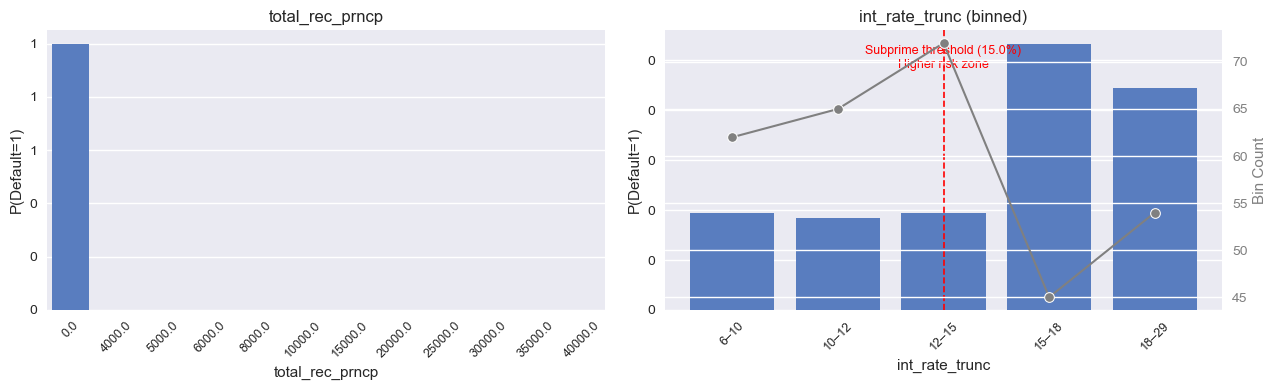

Skipped features:
  revol_bal: all bins below min_bin_count
  last_pymnt_amnt: low separation (<0.02)
  dti: all bins below min_bin_count
  tot_hi_cred_lim: all bins below min_bin_count
  avg_cur_bal: all bins below min_bin_count
  total_pymnt: low separation (<0.02)
  total_pymnt_inv: low separation (<0.02)





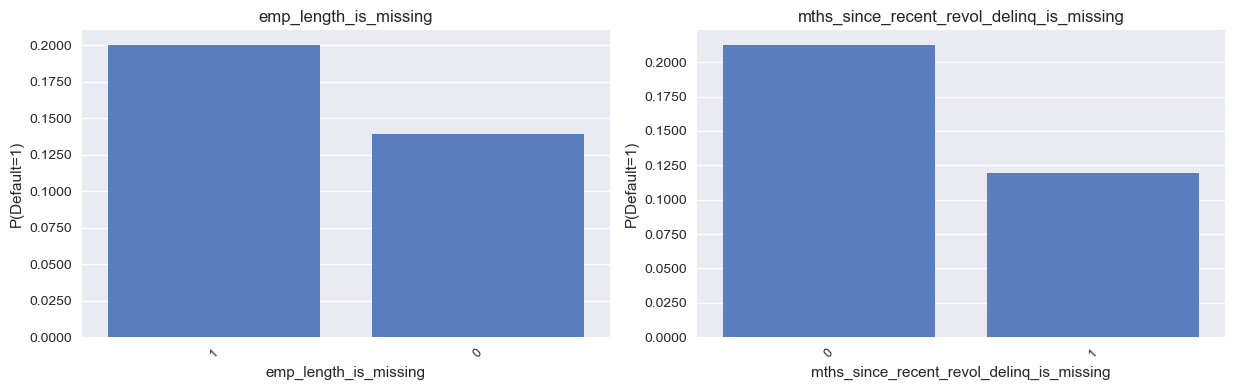

Skipped features:
  mths_since_recent_inq_is_missing: missing column





In [119]:
#df_uncorr2["int_rate_trunc"] = df_uncorr2["int_rate"].round(4)
df_uncorr2["int_rate_trunc"] = (df_uncorr2["int_rate"] * 10000).astype(int) / 10000


# All numeric features with high non-null counts
num_feats = ["revol_bal", "last_pymnt_amnt", "dti", "total_rec_prncp", "int_rate_trunc",
             "tot_hi_cred_lim", "avg_cur_bal", "total_pymnt", "total_pymnt_inv"]

# All binary and categorical features
cat_feats = ["emp_length_is_missing", "mths_since_recent_inq_is_missing", 
             "mths_since_recent_revol_delinq_is_missing"]

reasons_num = plot_default_prob_grid_strict(
    df_uncorr2, num_feats, target="target_default",
    n_cols=3, bins=5, strategy="quantile",
    min_bin_count=5, eps_diff=0.02, decimals=0
)
reasons_cat = plot_default_prob_grid_strict(
    df_uncorr2, cat_feats, target="target_default",
    n_cols=3, min_bin_count=5, eps_diff=0.02
    
)
#print(reasons_cat,"\n",reasons_num)

In [120]:
#diag_tables = diag_default_rates(df_uncorr2, num_feats, cat_feats)

# Print one or loop through
#for feat, tab in diag_tables.items():
 #   print(f"\n=== {feat} ===")
  #  print(tab.head())


In [121]:
# Dropping columns from reasons dicts that have no impact to outcome. 
reasons_cat = {'mths_since_recent_inq_is_missing': 'low separation (<0.02)'}
reasons_num = {
    'revol_bal': 'all categories below min_bin_count',
    'last_pymnt_amnt': 'low separation (<0.02)',
    'dti': 'all categories below min_bin_count',
    'tot_hi_cred_lim': 'all categories below min_bin_count',
    'avg_cur_bal': 'all categories below min_bin_count',
    'total_pymnt': 'low separation (<0.02)',
    'total_pymnt_inv': 'low separation (<0.02)'
}

# Features that failed diagnostic
to_drop = set(reasons_cat.keys()) | set(reasons_num.keys())
print("Dropping:", to_drop)

# Drop from your dataframe
df_reduced = df_uncorr2.drop(columns=list(to_drop), errors="ignore")

print("Before:", df_uncorr2.shape, "After:", df_reduced.shape)


Dropping: {'dti', 'tot_hi_cred_lim', 'total_pymnt_inv', 'total_pymnt', 'mths_since_recent_inq_is_missing', 'revol_bal', 'avg_cur_bal', 'last_pymnt_amnt'}
Before: (10000, 62) After: (10000, 55)


In [122]:
features_to_keep = df_reduced.columns.tolist()
print(len(features_to_keep))

55


<div style="border:2px solid #2196F3; border-radius:8px; padding:12px; background-color:#F0F8FF">

### 📊 Feature Reduction Progress — Current Status (~54 Features)

- **From 117 → 80:**  
  Weak categorical features were removed using Chi² and Mutual Information tests.  

- **From 80 → 55:**  
  Additional features were dropped after diagnostic probability-plots flagged:  
  - *Low separation* (<0.02 difference in default rates across bins/categories)  
  - *Too sparse* (all bins below minimum count)  

- **Current Feature Set:** **54 columns** remain, representing a lean, information-rich dataset.  

- **Why this matters:**  
  - Removes noise and target leakage  
  - Improves interpretability  
  - Keeps modeling efficient and robust  

</div>


In [123]:
#features_to_keep = list(features_to_keep) # Ensure it's a list if it was a set

# Specify the filename
filename = 'data/processed/columns_to_keep.txt'

# Save the list to a text file
with open(filename, 'w') as f:
    for item in features_to_keep:
        f.write(f"{item}\n")

print(f"Sample Column names successfully saved to {filename}")

# Save the df
out_path = "data/processed/loan_default_slim55.parquet" if USE_SAMPLE else "data/processed/loan_default_full55.parquet"
df_reduced.to_parquet(out_path, index=False)

Column names successfully saved to data/processed/columns_to_keep.txt


<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff">

<h3>📊 EDA Summary — Loan Default Probability (Notebook 1)</h3>

**Dataset & Structure**  
- LendingClub loan-level dataset (~2.4GB), reduced to a manageable sample (100k rows) for exploratory work.  
- Initial cleaning (high-NA drop, constants, dtype optimization) reduced features from ~145 → **117**.  
- Weak categorical features and correlated pairs removed → **80 features**.  
- Diagnostic probability plots flagged uninformative or low-separation features → **final 54 features** retained.  
- Column names saved in <code>columns_to_keep.txt</code> for reproducibility with the full dataset.  

**Target**  
- <b>target_default</b>: Binary outcome (0 = fully paid, 1 = default/charged off).  
- Imbalanced distribution: defaults ~15–20%. Modeling will focus on calibrated probabilities, not hard labels.

**Key Findings**  
- <b>Interest Rate (int_rate):</b> clear separation; higher rates correlate strongly with higher default probability.  
- <b>Debt-to-Income Ratio (dti):</b> moderate separation, with rising default rates at higher DTI levels.  
- <b>Employment Length Missingness (emp_length__is_missing):</b> missing values associate with higher default risk.  
- <b>Repayment-amount features</b> (e.g., total_rec_prncp, total_pymnt) flagged as potential target leakage and removed.  
- Many engineered “__is_missing” flags offered no useful separation and were pruned.

**Implications for Preprocessing (Notebook 2)**  
- **Feature Set:** Proceed with 54 features — lean, interpretable, and consistent with sample/full alignment.  
- **Encoding:** Remaining categoricals to be one-hot or label encoded.  
- **Scaling:** Plan for Robust/Standard scaling on skewed continuous features.  
- **Imbalance Handling:** Optimize recall/precision tradeoffs with class weights or resampling.  
- **Reproducibility:** Full dataset will be slimmed to this same 54 features before modeling.

**Ready for Next Step**  
Proceed to <b>Notebook 2</b> for preprocessing pipeline (encoding, scaling), baseline model training, and probability calibration.

</div>


In [143]:
features_to_keep = df_full_reduced.columns.tolist()
print(len(features_to_keep))

# Specify the filename
filename = 'data/processed/full_columns_to_keep.txt'

# Save the list to a text file
with open(filename, 'w') as f:
    for item in features_to_keep:
        f.write(f"{item}\n")

print(f"Full Column names successfully saved to {filename}")


51
Full Column names successfully saved to data/processed/full_columns_to_keep.txt


In [139]:
# Define file paths
csv_path = "data/raw/loan_default_probability_raw.csv"
parq_path = "data/processed/loan_default_full.parquet"

# Check if the processed parquet file exists
if os.path.exists(parq_path):
    print(f"✅ Loaded from processed file: {parq_path}")
    df_in = pd.read_parquet(parq_path)
else:
    print(f"⚠️ Processed file not found. Loading from raw CSV: {csv_path}")
    df_in = pd.read_csv(csv_path)
    
# 1) Clean & reduce full input
df_full, art = clean_and_reduce(df_in, na_thresh=0.95, ind_thresh=0.05, impute=True)

# 2) Add engineered + target columns
df_full["int_rate_trunc"] = (df_full["int_rate"] * 10000).astype(int) / 10000
df_full["target_default"] = df_full["loan_status"].apply(label_default)

# 3) Dedup-safe finalize & save
want = list(dict.fromkeys(list(features_to_keep) + ["target_default"]))  # ensure unique, ordered

if df_full.columns.duplicated().any():
    dup_cols = df_full.columns[df_full.columns.duplicated()].tolist()
    print("⚠️ Dropping duplicate columns:", dup_cols)
    df_full = df_full.loc[:, ~df_full.columns.duplicated()]

missing = [c for c in want if c not in df_full.columns]
if missing:
    print("⚠️ Missing columns (skipped):", missing)

have = [c for c in want if c in df_full.columns]
df_full_reduced = df_full[have].copy()

df_full_reduced = df_full_reduced[df_full_reduced["target_default"].isin([0, 1])].copy()
df_full_reduced["target_default"] = df_full_reduced["target_default"].astype(int)

full_path = "data/processed/loan_default_full51.parquet"
df_full_reduced.to_parquet(full_path, index=False)
print(f"✅ Saved: {full_path}  shape={df_full_reduced.shape}")

print("Class balance:", df_full_reduced["target_default"].value_counts(normalize=True).round(3).to_dict())


⚠️ Processed file not found. Loading from raw CSV: data/raw/loan_default_probability_raw.csv
⚠️ Missing columns (skipped): ['revol_bal_joint', 'sec_app_mort_acc', 'sec_app_revol_util', 'sec_app_open_act_il_is_missing']
✅ Saved: data/processed/loan_default_full51.parquet  shape=(1329272, 51)
Class balance: {0: 0.784, 1: 0.216}


<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff">

<h3>✅ Notebook 1 Complete</h3>

<p>The LendingClub dataset has been successfully wrangled and reduced for efficient use. The outputs have been saved, preserving a core set of features for downstream analysis.</p>

<p>⚠️ <strong>Important Note on Feature Discrepancy</strong></p>
<p>While the goal was to retain 54 features, the final full dataset contains **50 features**, plus the target variable. This is because four columns—<code>revol_bal_joint</code>, <code>sec_app_mort_acc</code>, <code>sec_app_revol_util</code>, and <code>sec_app_open_act_il_is_missing</code>—were dropped due to extremely low variance within the complete dataset. The sample dataset did not exhibit this same characteristic, which is an important difference to note.</p>

<p><strong>Saved Outputs:</strong></p>
<ul>
  <li><code>loan_default_slim55.parquet</code> (a sampled version for exploration and model prototyping)</li>
  <li><code>loan_default_full51.parquet</code> (the complete dataset, reduced to 50 features and the target)</li>
</ul>

<p>⚠️ **Reminder:** Do **not** set <code>USE_SAMPLE=False</code> within this notebook as it requires significant memory and could cause a crash. The <code>full55</code> Parquet file has already been generated for your use in subsequent notebooks.</p>

<p>➡️ Next: Proceed to **Notebook 2 (Preprocessing & Baseline Models)**.</p>

</div>

In [124]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 28543.09 seconds
